# Audio Predictor Evaluation
This notebook helps to see how audio predictor synthesize voice using existing phonemes

In [1]:
# Base
import itertools
from glob import glob
from tqdm import tqdm
import math
import textgrid
import random

# ML
import torch
import torch.nn.functional as F
from torch.utils.data import DistributedSampler, DataLoader
from torch.utils.tensorboard import SummaryWriter
from IPython.display import Audio, display
from vocos import Vocos

# Local
from utils.misc import dict_to_object, plot_specgram, plot_waveform
from utils.dataset import prepare_textgrid_alignments
from supervoice.audio import spectogram, load_mono_audio
from supervoice.model_audio import AudioPredictor
from supervoice.tokenizer import Tokenizer
from supervoice.tensors import drop_using_mask
from train_config import config

In [2]:
device = "cuda"

# Vocoder
vocoder = torch.hub.load(repo_or_dir='ex3ndr/supervoice-vocoder', model='bigvsan')
vocoder = vocoder.to(device)
def do_vocoder(src):
    with torch.no_grad():
        return vocoder.generate(src)

# Tokenizer
tokenizer = Tokenizer(config)
phoneme_duration = config.audio.hop_size / config.audio.sample_rate

# Load index
files = glob("datasets/eval-aligned/**/*.TextGrid")
files = [f[len("datasets/eval-aligned/"):-len(".TextGrid")] for f in files]

# Load textgrids
tg = [textgrid.TextGrid.fromFile("datasets/eval-aligned/" + f + ".TextGrid") for f in files]

# Load audio
files = ["datasets/eval-prepared/" + f + ".wav" for f in files]

Using cache found in /home/steve/.cache/torch/hub/ex3ndr_supervoice-vocoder_master


In [3]:
# Data extractor
def extract_tokens(src, audio, condition = False):
    aligned_phonemes = prepare_textgrid_alignments(src, audio.shape[1], phoneme_duration, not condition)
    phonemes = []
    for t in aligned_phonemes:
        for i in range(t[1]):
            phonemes.append(t[0])
    tokens = tokenizer(phonemes)
    return tokens, phonemes

def audio_denormalize(src):
    return (src * config.audio.norm_std) + config.audio.norm_mean

def audio_normalize(src):
    return (src - config.audio.norm_mean) / config.audio.norm_std

def do_spectogram(src):
    return spectogram(src, config.audio.n_fft, config.audio.n_mels, config.audio.hop_size, config.audio.win_size, config.audio.mel_norm, config.audio.mel_scale, config.audio.sample_rate)

def empty_tokens(size):
    return torch.zeros((size)).long().to(device)

def empty_mask(size):
    return torch.ones((size)).bool().to(device)

### Load Model

In [4]:
model = AudioPredictor(config)
model = model.to(device)
checkpoint = torch.load(f'./output/audio_large_begin_end.pt', map_location="cpu")
model.load_state_dict(checkpoint['model'])
model.eval()
print("Predictor at ", checkpoint['step'])

Predictor at  483000


### Load audio with phonemes
This loads sample audio that we would be able to use to compare with synthesized one

Source audio


Re-synth audio


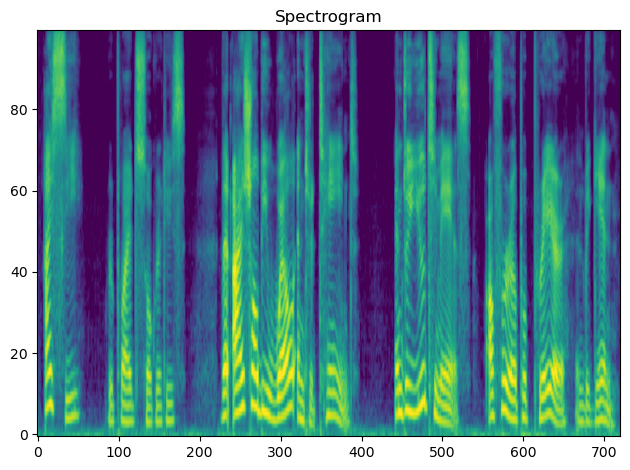

In [5]:
# Load audio
index = 55
waveform = load_mono_audio(files[index], sample_rate = config.audio.sample_rate)
spec = do_spectogram(waveform)
spec = spec.to(device)
tokens, _ = extract_tokens(tg[index], spec)
tokens = tokens.to(device)
spec = spec[:, :len(tokens)]

# Source audio
print("Source audio")
display(Audio(data=waveform, rate=config.audio.sample_rate))
print("Re-synth audio")
display(Audio(data=do_vocoder(spec).cpu(), rate=config.audio.sample_rate))
plot_specgram(spec.cpu())

Conditioning audio


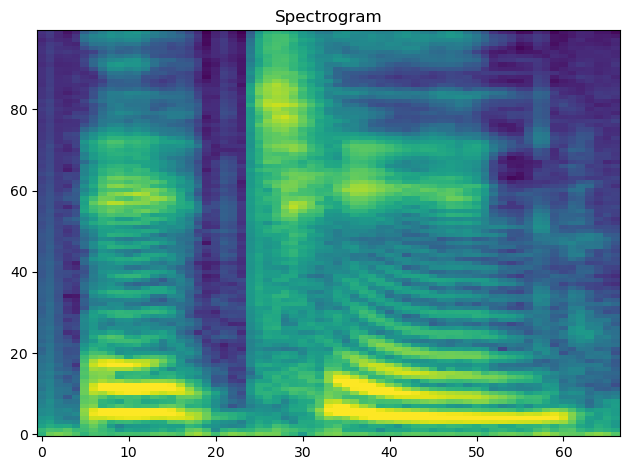

In [6]:
# Load conditioning audio
cond_index = 1007
# filename = "external_datasets/libritts-r-clean-100/60/121082/60_121082_000004_000001.wav
cond_waveform = load_mono_audio(files[cond_index], sample_rate = config.audio.sample_rate)
cond_spec = do_spectogram(cond_waveform)
cond_spec = cond_spec.to(device)
cond_tokens, _ = extract_tokens(tg[cond_index], cond_spec, True)
cond_tokens = cond_tokens.to(device)
cond_spec = cond_spec[:, :len(cond_tokens)]
assert len(cond_tokens) == cond_spec.shape[1]

# Source audio
print("Conditioning audio")
display(Audio(data=cond_waveform, rate=config.audio.sample_rate))
plot_specgram(cond_spec.cpu())

### Synthesize unconditioned voice

In [7]:
# with torch.no_grad():
#     sample_tokens = 250
#     sample, trajectory = model.sample(
#         tokens = empty_tokens(sample_tokens),
#         audio = torch.zeros((sample_tokens, config.audio.n_mels)).to(device),
#         mask = empty_mask(sample_tokens),
#         steps = 4
#     )
#     sample = audio_denormalize(sample)
#     trajectory = audio_denormalize(trajectory)

# # Resynth
# resynth = do_vocoder(sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)

# # Display audio
# print("Synthesized without any input")
# display(Audio(data=resynth, rate=config.audio.sample_rate))

# # Display trajectory
# # for i in reversed(range(len(trajectory))):
# #     plot_specgram(trajectory[i].transpose(1,0).cpu())    

# Synthesize voice from phonemes
This synthesizes random voice from existing phonemes (taken from another file)

In [8]:
with torch.no_grad():

    # Params
    s_steps = 4
    s_tokens = tokens
    s_audio = torch.zeros((len(tokens), config.audio.n_mels)).to(device)
    s_mask = empty_mask(len(tokens))

    # Synthesize
    sample, trajectory = model.sample(tokens = s_tokens, audio = s_audio, mask = s_mask, steps = s_steps, alpha = 0.5)
    sample = audio_denormalize(sample) * 1.2
    trajectory = audio_denormalize(trajectory)

# Resynth
resynth = do_vocoder(sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)

# Display audio
print("Source of phonemes")
display(Audio(data=waveform, rate=config.audio.sample_rate))
print("Synthesized with phonemes provided")
display(Audio(data=resynth, rate=config.audio.sample_rate))

# Display trajectory
# for i in reversed(range(len(trajectory))):
#     plot_specgram(trajectory[i].transpose(1,0).cpu())    

Source of phonemes


Synthesized with phonemes provided


### Restore segment
Cut part of the audio and re-generate segment

In [9]:
# with torch.no_grad():

#     # Params
#     s_steps = 4
#     s_tokens = empty_tokens(len(tokens))
#     s_audio = audio_normalize(spec.transpose(1,0))

#     # Mask
#     seq_len = len(tokens)
#     s_mask = torch.zeros((seq_len)).bool().to(device)
#     s_mask[math.floor(seq_len * 0.2): math.floor(seq_len * 0.6)] = True
#     s_audio = drop_using_mask(s_audio, 0, s_mask)

#     # Restore audio
#     sample, trajectory = model.sample(tokens = s_tokens, audio = s_audio, mask = s_mask, steps = s_steps)
#     sample = audio_denormalize(sample)
#     trajectory = audio_denormalize(trajectory)

# # Resynth
# resynth = do_vocoder(sample.transpose(1,0).to(device)).detach().cpu()

# # Display audio
# print("Source")
# display(Audio(data=waveform, rate=config.audio.sample_rate))
# print("Restored segment without tokens provided")
# display(Audio(data=resynth, rate=config.audio.sample_rate))

# # Display trajectory
# plot_specgram(sample.transpose(1,0).cpu())
# # for i in reversed(range(len(trajectory))):
# #     plot_specgram(trajectory[i].transpose(1,0).cpu())    

Source


Restored segment with tokens provided


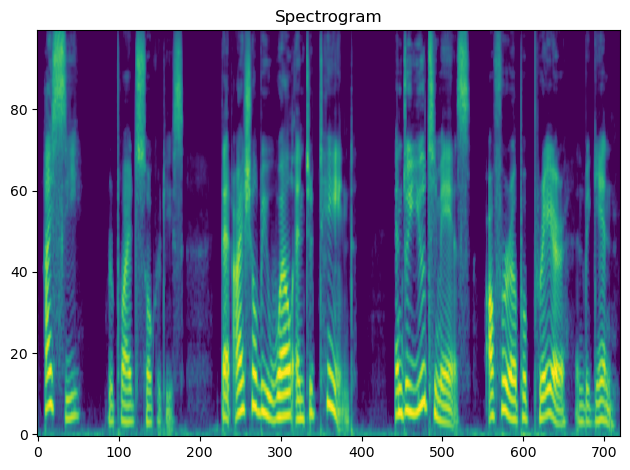

In [10]:
with torch.no_grad():

    # Params
    s_steps = 4
    s_tokens = tokens
    s_audio = audio_normalize(spec.transpose(1,0))

    # Mask
    seq_len = len(tokens)
    s_mask = torch.zeros((seq_len)).bool().to(device)
    s_mask[math.floor(seq_len * 0.2): math.floor(seq_len * 0.6)] = True
    s_audio = drop_using_mask(s_audio, 0, s_mask)

    # Restore audio
    sample, trajectory = model.sample(tokens = s_tokens, audio = s_audio, mask = s_mask, steps = s_steps)
    sample = audio_denormalize(sample) * 1.2
    trajectory = audio_denormalize(trajectory)

# Resynth
resynth = do_vocoder(sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)

# Display audio
print("Source")
display(Audio(data=waveform, rate=config.audio.sample_rate))
print("Restored segment with tokens provided")
display(Audio(data=resynth, rate=config.audio.sample_rate))

# Display trajectory
plot_specgram(sample.transpose(1,0).cpu())
# for i in reversed(range(len(trajectory))):
#     plot_specgram(trajectory[i].transpose(1,0).cpu())    

### Conditioned TTS

In [11]:
with torch.no_grad():

    # Params
    s_steps = 8
    s_audio = audio_normalize(torch.cat([cond_spec.transpose(1,0), torch.zeros(len(tokens), config.audio.n_mels, device=device)]))

    # Create tokens
    s_tokens = torch.cat([cond_tokens, tokens])
    s_tokens[0] = tokenizer.begin_token_id
    s_tokens[-1] = tokenizer.end_token_id

    # Create a mask
    s_mask = torch.zeros((len(cond_tokens) + len(tokens))).bool().to(device)
    s_mask[len(cond_tokens):len(cond_tokens) + len(tokens)] = True

    # Restore audio
    sample, trajectory = model.sample(tokens = s_tokens, audio = s_audio, mask = s_mask, steps = s_steps, alpha = 0.5)
    sample = audio_denormalize(sample)
    trajectory = audio_denormalize(trajectory)
    sample = sample[len(cond_tokens):] * 1.2
    trajectory = trajectory[:,len(cond_tokens):]

# Resynth
resynth = do_vocoder(sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)

# Display audio
print("Source audio of phonemes and durations")
display(Audio(data=waveform, rate=config.audio.sample_rate))
print("Synthesized voice")
display(Audio(data=resynth, rate=config.audio.sample_rate))

# Display trajectory
# for i in reversed(range(len(trajectory))):
#     plot_specgram(trajectory[i].transpose(1,0).cpu())    

Source audio of phonemes and durations


Synthesized voice


### Variativity

In [12]:
for i in range(10):
    with torch.no_grad():
        sample, trajectory = model.sample(
            tokens = tokens, 
            audio = torch.zeros((len(tokens), config.audio.n_mels)).to(device),  # Empty source audio
            mask = torch.ones((len(tokens))).bool().to(device), # Mask everything
            steps = 4
        )
        sample = audio_denormalize(sample) * 1.1
        resynth = do_vocoder(sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)
        display(Audio(data=resynth, rate=config.audio.sample_rate))
        # plot_specgram(sample.transpose(1,0).cpu())    

# Resynth
# resynth = generator(sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)

# # Display audio
# display(Audio(data=waveform, rate=config.audio.sample_rate))
# display(Audio(data=resynth, rate=config.audio.sample_rate))

# # Display trajectory
# for i in reversed(range(len(trajectory))):
#     plot_specgram(trajectory[i].transpose(1,0).cpu())    

In [31]:
eval = [('m', 9), ('aj', 9), ('•', 0), ('ɲ', 10), ('ej', 17), ('m', 7), ('•', 0), ('ɪ', 5), ('z', 8), ('•', 0), ('æ', 13), ('d', 4), ('ə', 6), ('m', 14)]
speedup = 1.25
eval = [(char.replace('•', '<SIL>'), duration) for char, duration in eval]
eval = [char for char, duration in eval for _ in range(round(duration * speedup))]

with torch.no_grad():

    # Params
    s_steps = 32
    s_tokens = torch.cat([torch.tensor([tokenizer.begin_token_id]), tokenizer(eval), torch.tensor([tokenizer.end_token_id])])
    s_tokens = s_tokens.to(device)
    s_audio = torch.zeros((len(s_tokens), config.audio.n_mels)).to(device)
    s_mask = empty_mask(len(s_tokens)).to(device)

    # Synthesize
    sample, trajectory = model.sample(tokens = s_tokens, audio = s_audio, mask = s_mask, steps = s_steps, alpha = 0.5)
    sample = audio_denormalize(sample)
    trajectory = audio_denormalize(trajectory)

# Resynth
resynth = do_vocoder(sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)

# Display audio
print("Synthesized sound")
display(Audio(data=resynth, rate=config.audio.sample_rate))

Synthesized sound
